---
title: "Evaluacion del rendimiento de modelos"
date: 2022-05-03T17:30:50+02:00
tags: [dummy, baseline, kfold, stratification, estratificación, ShuffleSplit]
categories: [tutoriales]
---

En anteriores posts vimos el framework general de validación cruzada y su uso para evaluar el rendimiento de modelos. Sin embargo, es importante tener en cuenta que algunos elementos de la validación cruzada deben decidirse en función de la naturaleza del problema: (i) la estrategia de validación cruzada y (ii) las métricas de evaluación. Además, siempre es bueno comparar el rendimiento de los modelos respecto de alguna línea base.

En este post presentaremos ambos aspectos y ofreceremos intuiciones e ideas de cuándo usar una estrategia de validación cruzada y métrica específicas. Además, también daremos algunas ideas sobre cómo comparar un modelo con alguna línea base.

Como objetivos generales intentaremos:

+ comprender la necesidad de usar una estrategia adecuada de validación cruzada dependiendo de los datos;
+ obtener las intuiciones y principios que hay detrás del uso de la validación cruzada anidada cuando el modelo necesita ser evaluado y optimizado;
+ comprender las diferencias entre las métricas de regresión y clasificación;
+ comprender las diferencias entre métricas.

# Comparación del rendimiento del modelo con una línea base simple

Vamos a ver cómo comparar el rendimiento de generalización de un modelo con una mínima linea base. En regresión, podemos usar la clase `DummyRegressor` para predecir el valor medio del objetivo observado en el conjunto de entrenamiento sin usar las variables de entrada.

Demostraremos cómo calcular la puntuación de un modelo de regresión y compararlo con una línea base en el dataset de viviendas de California.

In [65]:
from sklearn.datasets import fetch_california_housing

X, y = fetch_california_housing(return_X_y=True, as_frame=True)
y *= 100  # reescala el objetivo en k$

En todas las evaluaciones usaremos un divisor de validación cruzada `ShuffleSplit` con el 20% de los datos reservados para validación.

In [66]:
from sklearn.model_selection import ShuffleSplit

cv = ShuffleSplit(n_splits=30, test_size=0.2, random_state=0)

Empezaremos ejecutando la validación cruzada para un simple árbol de decisión regresor, que es nuestro modelo de interés. Además, almacenaremos el error de prueba en un objeto serie de pandas para hacer más sencillo dibujar los resultados.

In [67]:
import pandas as pd
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_validate

regressor = DecisionTreeRegressor()
cv_results_tree_regressor = cross_validate(
    regressor, X, y, cv=cv, scoring="neg_mean_absolute_error", n_jobs=-1
)

errors_tree_regressor = pd.Series(
    -cv_results_tree_regressor["test_score"], name="Arbol decisión regresor"
)
errors_tree_regressor.describe()

count    30.000000
mean     45.710415
std       1.259505
min      43.027584
25%      44.718032
50%      45.727282
75%      46.676746
max      48.324053
Name: Arbol decisión regresor, dtype: float64

Luego, evaluamos nuestra línea base.  Esta línea base se denomina regresor dummy. Este regresor dummy siempre predecirá la media del objetivo calculada en la variable objetivo de entrenamiento. Por lo tanto, el regresor dummy no usa ninguna información de las variables de entrada almacenadas en el dataframe llamado `X`.

In [68]:
from sklearn.dummy import DummyRegressor

dummy = DummyRegressor(strategy="mean")
result_dummy = cross_validate(
    dummy, X, y, cv=cv, scoring="neg_mean_absolute_error", n_jobs=-1
)
errors_dummy_regressor = pd.Series(
    -result_dummy["test_score"], name="Regresor dummy"
)
errors_dummy_regressor.describe()

count    30.000000
mean     91.140009
std       0.821140
min      89.757566
25%      90.543652
50%      91.034555
75%      91.979007
max      92.477244
Name: Regresor dummy, dtype: float64

Ahora dibujaremos los errores de prueba de la validación cruzada para la línea base usando la media del objetivo y el actual árbol de decisión regresor.

In [69]:
all_errors = pd.concat(
    [errors_tree_regressor, errors_dummy_regressor],
    axis=1,
)
all_errors

,Arbol decisión regresor,Regresor dummy
0,46.618549,90.713153
1,46.696145,90.539353
2,44.085143,91.941912
3,43.902195,90.213912
4,48.324053,92.015862
5,44.699191,90.542490
6,43.951106,89.757566
7,44.559802,92.477244
8,45.341463,90.947952
9,44.530054,91.991373


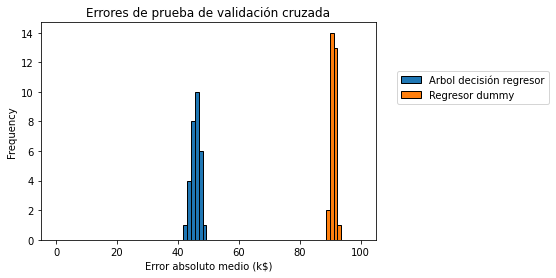

In [70]:
import matplotlib.pyplot as plt
import numpy as np

bins = np.linspace(start=0, stop=100, num=80)
all_errors.plot.hist(bins=bins, edgecolor="black")
plt.legend(bbox_to_anchor=(1.05, 0.8), loc="upper left")
plt.xlabel("Error absoluto medio (k$)")
_ = plt.title("Errores de prueba de validación cruzada")

Vemos que el rendimiento de generalización de nuestro ábol de decisión está lejos de ser perfecto: las predicciones del precio tiene aproximadamente un márgen de error de 45000 dólares de media. Sin embargo, es mucho mejor que el margen de error de la línea base. Por tanto, esto confirma que es posible predecir mucho mejor el precio de la vivienda usando un modelo que tenga en cuenta los valores de las variables de entrada (localización de la propiedad, tamaño, ingresos del vecindario, etc.). Dicho modelo hace predicciones más formadas y, aproximadamente, divide la tasa de error por la mitad comparado con la línea base que ignora las variables de entrada.

Observemos que hemos usado la media del precio como predicción de línea base. Podríamos haber usado en su lugar la mediana. Véase la documentación online de la clase [`sklearn.dummy.DummyRegressor`](https://scikit-learn.org/stable/modules/generated/sklearn.dummy.DummyRegressor.html) para otras opciones. Para este ejemplo en particular, no existe mucha diferencia entre usar la media en lugar de la mediana, pero este podría ser el caso de un dataset con valores atípicos extremos.

## Ejercicio

Vamos a poner en práctica lo aprendido hasta ahora. Definiremos una línea base con un clasificador dummy y lo usaremos como referencia para evaluar el rendimiento predictivo relativo de un modelo de interés dado.

Ilustraremos dicha línea base con la ayuda del dataset del censo de adultos, usando únicamente las variables numéricas, por simplicidad.

In [71]:
adult_census = pd.read_csv("../data/adult-census-numeric-all.csv")
X, y = adult_census.drop(columns="class"), adult_census["class"]

Primero definiremos una estrategia de validación cruzada con `ShuffleSplit` tomando la mitad de las muestras como prueba en cada ciclo. Usaremos 10 ciclos de validación cruzada.

In [72]:
cv = ShuffleSplit(n_splits=10, test_size=0.5, random_state=0)

Lo siguiente es crear un pipeline de machine learning compuesto por un transformador para estandarizar los datos seguido por un clasificador de regresión logística.

In [73]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline

classifier = make_pipeline(StandardScaler(), LogisticRegression())


Calculemos ahora las puntuaciones de prueba de validación cruzada para el clasificador en este dataset y almacenaremos los resultados en una Series de panda.

In [74]:
from sklearn.model_selection import cross_validate

cv_results_logistic_regression = cross_validate(
    classifier, X, y, cv=cv, n_jobs=-1)

test_score_logistic_regression = pd.Series(
    cv_results_logistic_regression["test_score"], name="Regresión logística"
)
test_score_logistic_regression

0    0.815937
1    0.813849
2    0.815036
3    0.815569
4    0.810982
5    0.814709
6    0.813112
7    0.810327
8    0.812416
9    0.816388
Name: Regresión logística, dtype: float64

Ahora calcularemos las puntuaciones de validación cruzada de un clasificador dummy que prediga constantemente la clase más frecuente observada en el conjunto de entrenamiento. Almacenaremos los resultados en un Series de panda.

In [75]:
from sklearn.dummy import DummyClassifier

dummy_most_frequent = DummyClassifier(strategy="most_frequent")
result_dummy = cross_validate(
    dummy_most_frequent, X, y, cv=cv, n_jobs=-1
)
test_dummy_most_frequent = pd.Series(
    result_dummy["test_score"], name="Most-frequent dummy"
)
test_dummy_most_frequent

0    0.760329
1    0.756808
2    0.759142
3    0.760739
4    0.761681
5    0.761885
6    0.757463
7    0.757176
8    0.761885
9    0.763114
Name: Most-frequent dummy, dtype: float64

Ahora que hemos recopilado los resultados tanto de la línea base como del modelo, vamos a concatenar las puntuaciones de prueba como columnas en un dataframe de pandas.

In [76]:
all_scores = pd.concat(
    [test_score_logistic_regression, test_dummy_most_frequent],
    axis=1,
)
all_scores

,Regresión logística,Most-frequent dummy
0,0.815937,0.760329
1,0.813849,0.756808
2,0.815036,0.759142
3,0.815569,0.760739
4,0.810982,0.761681
5,0.814709,0.761885
6,0.813112,0.757463
7,0.810327,0.757176
8,0.812416,0.761885
9,0.816388,0.763114


Lo siguiente que haremos será dibujar el histograma de las puntuaciones de prueba de validación cruzada para ambos modelos con la ayuda de la [función de dibujado incorporada en pandas](https://pandas.pydata.org/pandas-docs/stable/user_guide/visualization.html#histograms). ¿Qué conclusiones obtenemos de los resultados?

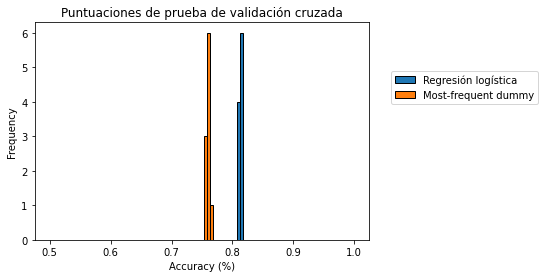

In [77]:
import matplotlib.pyplot as plt
import numpy as np

bins = np.linspace(start=0.5, stop=1.0, num=100)
all_scores.plot.hist(bins=bins, edgecolor="black")
plt.legend(bbox_to_anchor=(1.05, 0.8), loc="upper left")
plt.xlabel("Accuracy (%)")
_ = plt.title("Puntuaciones de prueba de validación cruzada")

Observamos que los dos histogramas están bien separados. Por lo tanto el clasificador dummy con la estrategia `most_frequent` tiene mucha menos precisión que el clasificador de regresión logística. Podemos concluir que el modelo de regresión logística puede encontrar satisfactoriamente información predictiva en las variables de entrada para mejorar la línea base.

Por último, vamos a cambiar la estrategia del clasificador dummy a `"stratified"` y calcularemos los resultados. De igual forma, calcularemos las puntuaciones para la `strategy="uniform"` y después dibujaremos la distribución conjuntamente con los otros resultados.

¿Estas nuevas líneas base son mejores que la previa? ¿Por qué es este el caso?

Podemos consultar la documentación de [`sklearn.dummy.DummyClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.dummy.DummyClassifier.html) para conocer el significado de estas estrategias.

In [78]:
dummy_stratified = DummyClassifier(strategy="stratified")
result_dummy_stratified = cross_validate(
    dummy_stratified, X, y, cv=cv, n_jobs=-1
)
test_dummy_stratified = pd.Series(
    result_dummy_stratified["test_score"], name="Stratified dummy"
)
test_dummy_stratified

0    0.632775
1    0.629868
2    0.636993
3    0.636256
4    0.631710
5    0.638262
6    0.633799
7    0.635273
8    0.637075
9    0.634618
Name: Stratified dummy, dtype: float64

In [79]:
dummy_uniform = DummyClassifier(strategy="uniform")
result_dummy_uniform = cross_validate(
    dummy_uniform, X, y, cv=cv, n_jobs=-1
)
test_dummy_uniform = pd.Series(
    result_dummy_uniform["test_score"], name="Uniform dummy"
)
test_dummy_uniform

0    0.500348
1    0.499857
2    0.501945
3    0.494124
4    0.501986
5    0.502846
6    0.497195
7    0.500225
8    0.498792
9    0.501331
Name: Uniform dummy, dtype: float64

In [80]:
all_scores = pd.concat(
    [test_score_logistic_regression,
     test_dummy_most_frequent,
     test_dummy_stratified,
     test_dummy_uniform,],
    axis=1,
)
all_scores

,Regresión logística,Most-frequent dummy,Stratified dummy,Uniform dummy
0,0.815937,0.760329,0.632775,0.500348
1,0.813849,0.756808,0.629868,0.499857
2,0.815036,0.759142,0.636993,0.501945
3,0.815569,0.760739,0.636256,0.494124
4,0.810982,0.761681,0.631710,0.501986
5,0.814709,0.761885,0.638262,0.502846
6,0.813112,0.757463,0.633799,0.497195
7,0.810327,0.757176,0.635273,0.500225
8,0.812416,0.761885,0.637075,0.498792
9,0.816388,0.763114,0.634618,0.501331


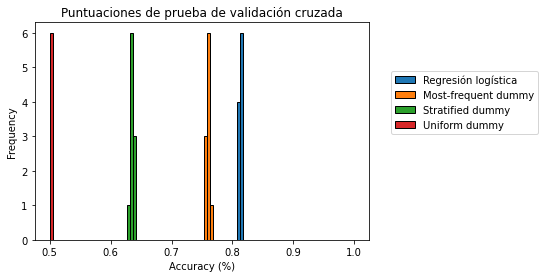

In [81]:
bins = np.linspace(start=0.5, stop=1.0, num=100)
all_scores.plot.hist(bins=bins, edgecolor="black")
plt.legend(bbox_to_anchor=(1.05, 0.8), loc="upper left")
plt.xlabel("Accuracy (%)")
_ = plt.title("Puntuaciones de prueba de validación cruzada")

Vemos que al usar `strategy="stratified"` los resultados son mucho peores que con la estrategia `most_frequent`. Dado que las clases están desbalanceadas, predecir la más frecuente implica que acertaremos en la proporción de esa clase (aproximadamente el 75% de las muestras), es decir, el 75% de las veces. Sin embargo, la estrategia `"stratified"` generará predicciones aleatoriamente respetando la distribución de las clases del conjunto de entrenamiento, lo que dará como resultado algunas predicciones incorrectas, incluso para la clase más frecuente, por lo tanto obtenemos una precisión menor.

Esto es aún más cierto para `strategy="uniform"`: esta estrategia asigna etiquetas de clase uniformemente al azar. Por lo tanto, en un problema de clasificación binaria, la precisión de validación cruzada es del 50% de media, por lo cual es la más débil de las tres líneas base dummy.

Nota: se podría argumentar que las estrategias `"uniform"` y `"stratified"` son maneras válidas de definir un "nivel de referencia" de la precisión de una línea base para el problema de clasificación, debido a que hacen predicciones "al azar".

Otra forma de definir un nivel de azar podría ser usando la utilidad de scikit-learn [sklearn.model_selection.permutation_test_score](https://scikit-learn.org/stable/auto_examples/model_selection/plot_permutation_tests_for_classification.html). En lugar de usar un clasificador dummy, esta función compara la precisión de validación cruzada de un modelo de interés con la precisión de validación cruzada de este mismo modelo pero entrenado en etiquetas de clase permutadas aleatoriamente. Por lo tanto, `permutation_test_score` define un nivel de azar que depende de la elección de la clase y los hiperparámetros del estimador de interés. Cuando entrenamos en tales etiquetas permutadas aleatoriamente, muchos estimadores de machine learning terminan comportándose aproximadamente como `DummyClassifier(strategy="most_frequent")`, prediciendo siempre la clase mayoritaria, independientemente de las variables de entrada. Como resultado, esta línea base `most_frequent` se llama algunas veces "nivel de azar" para problemas de clasificación desbalanceados, aunque sus predicciones son completamente deterministas y no involucran mucho azar.

Definir el nivel de azar usando `permutation_test_score` es bastante costoso computacionalmente, debido a que requiere entrenar muchos modelos no dummys en permutaciones aleatorias de los datos. Usar clasificadores dummys como líneas base suele ser suficiente para fines prácticos. Para problemas de clasificacion desbalanceados, la estrategia `most_frequent` es la más fuerte de las tres líneas bases y por tanto la que debemos usar.

# Elección de validación cruzada

## Estratificación

Generalmente hemos usado por defecto una estrategia de validación cruzada `KFold` o `ShuffleSplit` para dividir de forma iterativa nuestro dataset. Sin embargo, no debemos asumir que estos enfoques son siempre la mejor opción: otras estrategias de validación cruzada podrían adaptarse mejor a nuestro problema.

Comencemos con el concepto de estratificación, dando un ejemplo donde podemos tener problemas si no somos cuidadosos. Carguemos el dataset iris.

In [82]:
from sklearn.datasets import load_iris

X, y = load_iris(as_frame=True, return_X_y=True)

Vamos a crear un modelo de machine learning básico: una regresión logística. Esperamos que este modelo funcione bastante bien en el dataset iris, ya que es un dataset bastante simple.

In [83]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(), LogisticRegression())

Una vez que hemos creado nuestro modelo, usaremos validación cruzada para evaluarlo. Usaremos la estrategia `KFold`. Definiremos un dataset con nueve muestras y repetiremos la validación cruzada tres veces (es decir, `n_splits`).

In [84]:
import numpy as np
from sklearn.model_selection import KFold

X_random = np.random.randn(9, 1)
cv = KFold(n_splits=3)
for train_index, test_index in cv.split(X_random):
    print(f"ENTRENAMIENTO: {train_index}  PRUEBA: {test_index}")

ENTRENAMIENTO: [3 4 5 6 7 8]  PRUEBA: [0 1 2]
ENTRENAMIENTO: [0 1 2 6 7 8]  PRUEBA: [3 4 5]
ENTRENAMIENTO: [0 1 2 3 4 5]  PRUEBA: [6 7 8]


Al definir tres divisiones, usaremos tres muestras para prueba y seis para entrenamiento cada vez. `KFold` por defecto no baraja. Lo que significa que seleccionará las tres primeras muestras para el conjunto de prueba en la primera división, luego las tres siguientes muestras para la segunda división y las siguientes tres para la última división. Al final, todas las muestras se habrán usado en la prueba al menos una vez entre las diferentes divisiones.

Ahora  vamos a aplicar esta estrategia para verificar el rendimiento de generalización de nuestro modelo.

In [85]:
from sklearn.model_selection import cross_validate

cv = KFold(n_splits=3)
results = cross_validate(model, X, y, cv=cv)
test_score = results["test_score"]
print(f"La precisión media es: "
      f"{test_score.mean():.3f} +/- {test_score.std():.3f}")

La precisión media es: 0.000 +/- 0.000


Es una sorpresa real que nuestro modelo no pueda clasificar correctamente ninguna muestra en ninguna división de validación cruzada. Comprobemos nuestros valores de objetivo para comprender el problema.

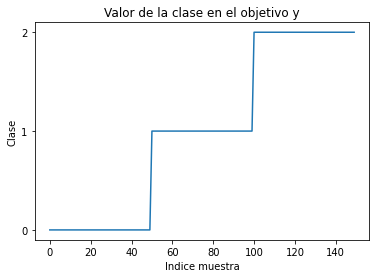

In [86]:
import matplotlib.pyplot as plt

y.plot()
plt.xlabel("Indice muestra")
plt.ylabel("Clase")
plt.yticks(y.unique())
_ = plt.title("Valor de la clase en el objetivo y")

Vemos que el vector objetivo `y` está ordenado. Tendrá algunas consecuencias inesperadas cuando usemos la validación cruzada `KFold`. Para ilustrar las consecuencias, mostraremos el recuento de clases en cada partición de la validación cruzada en los conjuntos de entrenamiento y prueba y dibujaremos esta información en un bar plot.

In [87]:
import pandas as pd

n_splits = 3
cv = KFold(n_splits=n_splits)

train_cv_counts = []
test_cv_counts = []
for fold_idx, (train_idx, test_idx) in enumerate(cv.split(X, y)):
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    train_cv_counts.append(y_train.value_counts())
    test_cv_counts.append(y_test.value_counts())

In [88]:
train_cv_counts = pd.concat(train_cv_counts, axis=1,
                            keys=[f"Partición #{idx}" for idx in range(n_splits)])
train_cv_counts.index.name = "Etiqueta clase"
train_cv_counts

,Partición #0,Partición #1,Partición #2
Etiqueta clase,,,
1,50.0,NaN,50.0
2,50.0,50.0,NaN
0,NaN,50.0,50.0


In [89]:
test_cv_counts = pd.concat(test_cv_counts, axis=1,
                           keys=[f"Partición #{idx}" for idx in range(n_splits)])
test_cv_counts.index.name = "Etiqueta  clase"
test_cv_counts

,Partición #0,Partición #1,Partición #2
Etiqueta clase,,,
0,50.0,NaN,NaN
1,NaN,50.0,NaN
2,NaN,NaN,50.0


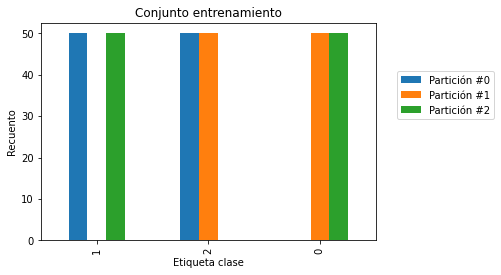

In [90]:
train_cv_counts.plot.bar()
plt.legend(bbox_to_anchor=(1.05, 0.8), loc="upper left")
plt.ylabel("Recuento")
_ = plt.title("Conjunto entrenamiento")

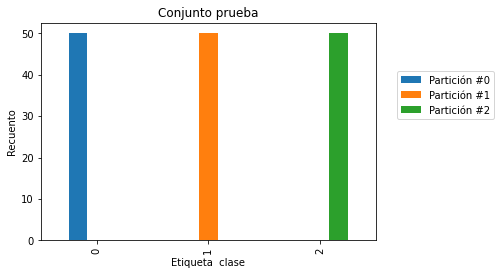

In [91]:
test_cv_counts.plot.bar()
plt.legend(bbox_to_anchor=(1.05, 0.8), loc="upper left")
plt.ylabel("Recuento")
_ = plt.title("Conjunto prueba")

Podemos confirmar que en cada partición del conjunto de entrenamiento solo están presentes dos de las tres clases y todas las muestras de la clase restante se usan como conjunto de prueba. Por tanto, nuestro modelo es incapaz de predecir esta clase que no ha sido visto nunca durante la fase de entrenamiento.

Una posibilidad para resolver este problema es barajar los datos antes de dividirlos en los tres grupos.

In [92]:
cv = KFold(n_splits=3, shuffle=True, random_state=0)
results = cross_validate(model, X, y, cv=cv)
test_score = results["test_score"]
print(f"La precisión media es: "
      f"{test_score.mean():.3f} +/- {test_score.std():.3f}")

La precisión media es: 0.953 +/- 0.009


Obtenemos un resultado que está más cercano a lo se podría esperar con una precisión por encima del 90%. Ahora que hemos resulto nuestro primer problema, podría ser interesante comprobar si la frecuencia de clases en el conjunto de entrenamiento y prueba son iguales que las de nuestro dataset original. Aseguraría que estamos entrenando y probando nuestro modelo con una distribución de clases que encontaremos en producción.

In [93]:
train_cv_counts = []
test_cv_counts = []
for fold_idx, (train_idx, test_idx) in enumerate(cv.split(X, y)):
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    train_cv_counts.append(y_train.value_counts())
    test_cv_counts.append(y_test.value_counts())
train_cv_counts = pd.concat(train_cv_counts, axis=1,
                            keys=[f"Partición #{idx}" for idx in range(n_splits)])
test_cv_counts = pd.concat(test_cv_counts, axis=1,
                           keys=[f"Partición #{idx}" for idx in range(n_splits)])
train_cv_counts.index.name = "Etiqueta clase"
test_cv_counts.index.name = "Etiqueta clase"

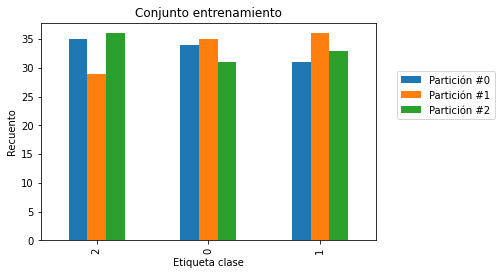

In [94]:
train_cv_counts.plot.bar()
plt.legend(bbox_to_anchor=(1.05, 0.8), loc="upper left")
plt.ylabel("Recuento")
_ = plt.title("Conjunto entrenamiento")

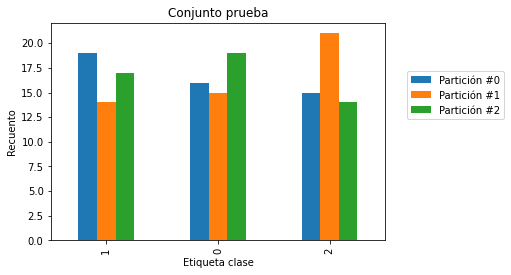

In [95]:
test_cv_counts.plot.bar()
plt.legend(bbox_to_anchor=(1.05, 0.8), loc="upper left")
plt.ylabel("Recuento")
_ = plt.title("Conjunto prueba")

Vemos que ni el conjunto de entrenamiento ni el de prueba tienen las mismas frecuencias de clase que nuestro dataset original debido a que el recuento de cada clase varía un poco.

Sin embargo, podríamos querer dividir nuestros datos preservando las frecuencias de clase originales: queremos **estratificar** nuestros datos por clase. En scikit-learn, algunas estrategias de validación cruzada implementan la estratificación; contienen `Stratified` en sus nombres.

In [96]:
from sklearn.model_selection import StratifiedKFold

cv = StratifiedKFold(n_splits=3)

In [97]:
results = cross_validate(model, X, y, cv=cv)
test_score = results["test_score"]
print(f"La precisión media es: "
      f"{test_score.mean():.3f} +/- {test_score.std():.3f}")

La precisión media es: 0.960 +/- 0.016


In [98]:
train_cv_counts = []
test_cv_counts = []
for fold_idx, (train_idx, test_idx) in enumerate(cv.split(X, y)):
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    train_cv_counts.append(y_train.value_counts())
    test_cv_counts.append(y_test.value_counts())
train_cv_counts = pd.concat(train_cv_counts, axis=1,
                            keys=[f"Partición #{idx}" for idx in range(n_splits)])
test_cv_counts = pd.concat(test_cv_counts, axis=1,
                           keys=[f"Partición #{idx}" for idx in range(n_splits)])
train_cv_counts.index.name = "Etiqueta clase"
test_cv_counts.index.name = "Etiqueta clase"

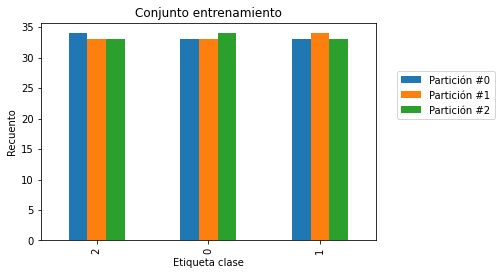

In [99]:
train_cv_counts.plot.bar()
plt.legend(bbox_to_anchor=(1.05, 0.8), loc="upper left")
plt.ylabel("Recuento")
_ = plt.title("Conjunto entrenamiento")

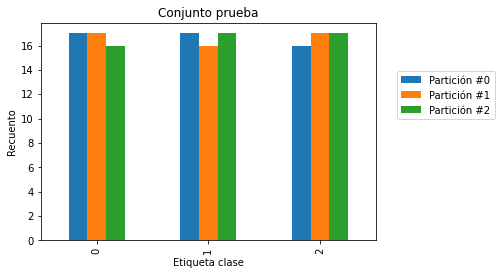

In [100]:
test_cv_counts.plot.bar()
plt.legend(bbox_to_anchor=(1.05, 0.8), loc="upper left")
plt.ylabel("Recuento")
_ = plt.title("Conjunto prueba")

En este caso, observamos que el recuento de clases es muy parecido entre el conjunto de entrenamiento y el conjunto de prueba. La diferencia es debida al pequeño número de muestras del dataset iris.

En conclusión, es una buena práctica usar estratificación dentro de la validación cruzada cuando se trata de un problema de clasificación.

## Agrupación de muestras

Vamos a detenernos en el concepto de grupos de muestras. Usaremos el dataset de dígitos escritos a mano.

In [101]:
from sklearn.datasets import load_digits

digits = load_digits()
X, y = digits.data, digits.target

Vamos a recrear el mismo modelo que vimos más arriba: un clasificador de regresión logística con preprocesamiento para escalar los datos.

In [102]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline

model = make_pipeline(MinMaxScaler(),
                      LogisticRegression(max_iter=1_000))

Usaremos el mismo modelo de línea base. Usaremos una validación cruzada `KFold` sin mezclar los datos al principio.

In [103]:
from sklearn.model_selection import cross_val_score, KFold

cv = KFold(shuffle=False)
test_score_no_shuffling = cross_val_score(model, X, y, cv=cv, n_jobs=-1)
print(f"La precisión media es: "
      f"{test_score_no_shuffling.mean():.3f} +/- "
      f"{test_score_no_shuffling.std():.3f}")

La precisión media es: 0.931 +/- 0.026


Ahora repitamos lo mismo mezclando los datos dentro de la validación cruzada.

In [104]:
cv = KFold(shuffle=True)
test_score_with_shuffling = cross_val_score(model, X, y, cv=cv, n_jobs=-1)
print(f"La precisión media es: "
      f"{test_score_with_shuffling.mean():.3f} +/- "
      f"{test_score_with_shuffling.std():.3f}")

La precisión media es: 0.968 +/- 0.004


Observamos que mezclar los datos mejora la precisión media. Podríamos ir un poco más allá y dibujar la distribución de la puntuación de prueba. Primero concatenemos las puntuaciones de prueba.

In [105]:
import pandas as pd

all_scores = pd.DataFrame(
    [test_score_no_shuffling, test_score_with_shuffling],
    index=["KFold sin mezclado", "KFold con mezclado"],
).T

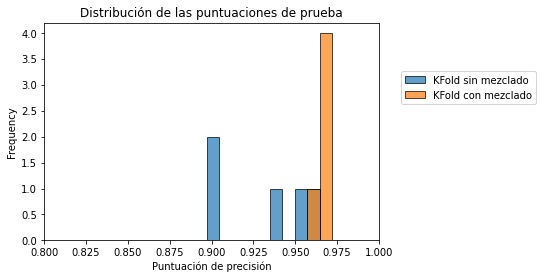

In [106]:
import matplotlib.pyplot as plt

all_scores.plot.hist(bins=10, edgecolor="black", alpha=0.7)
plt.xlim([0.8, 1.0])
plt.xlabel("Puntuación de precisión")
plt.legend(bbox_to_anchor=(1.05, 0.8), loc="upper left")
_ = plt.title("Distribución de las puntuaciones de prueba")

El error de prueba de validación cruzada que usa el mezclado tiene menos varianza que la que no impone ningún mezclado. Lo que significa que, en este caso, alguna partición específica conduce a una puntuación baja.

In [107]:
print(test_score_no_shuffling)

[0.94166667 0.89722222 0.94986072 0.9637883  0.90250696]


Por lo tanto, existe una estructura subyacente en los datos que al mezclarlos se rompe y se obtienen mejores resultados. Para tener una mejor comprensión, podríamos leer la documentación que acompaña al dataset.

In [108]:
print(digits.DESCR)

.. _digits_dataset:

Optical recognition of handwritten digits dataset
--------------------------------------------------

**Data Set Characteristics:**

    :Number of Instances: 1797
    :Number of Attributes: 64
    :Attribute Information: 8x8 image of integer pixels in the range 0..16.
    :Missing Attribute Values: None
    :Creator: E. Alpaydin (alpaydin '@' boun.edu.tr)
    :Date: July; 1998

This is a copy of the test set of the UCI ML hand-written digits datasets
https://archive.ics.uci.edu/ml/datasets/Optical+Recognition+of+Handwritten+Digits

The data set contains images of hand-written digits: 10 classes where
each class refers to a digit.

Preprocessing programs made available by NIST were used to extract
normalized bitmaps of handwritten digits from a preprinted form. From a
total of 43 people, 30 contributed to the training set and different 13
to the test set. 32x32 bitmaps are divided into nonoverlapping blocks of
4x4 and the number of on pixels are counted in each blo

Si leemos cuidadosamente, 13 personas escribieron los dígitos para nuestro dataset, lo que supone un total de 1797 muestras. Por tanto, una persona escribió varias veces el mismo número. Supongamos que las muestras de la persona están agrupadas. En consecuencia, no mezclar los datos mantendrá todas las muestras de la persona juntas, ya sea en el conjunto de entrenamiento como en el de prueba. Mezclar los datos romperá esta estructura y, por tanto, dígitos escritos por la misma persona estarán disponibles tanto en conjunto de entrenamiento como en el de prueba.

Además, por norma general, una persona tenderá a escribir los dígitos de la misma manera. Así, nuestro modelo aprenderá a identificar los patrones de una persona para cada dígito en lugar de reconocer el dígito en sí mismo.

Podemos resolver este problema asegurando que los datos asociados a una persona pertenezcan al conjunto de entrenamiento o al de prueba. Por tanto, queremos agrupar muestras para cada persona. De hecho, podemos recuperar los grupos mirando la variable objetivo.

In [109]:
y[:200]

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1,
       2, 3, 4, 5, 6, 7, 8, 9, 0, 9, 5, 5, 6, 5, 0, 9, 8, 9, 8, 4, 1, 7,
       7, 3, 5, 1, 0, 0, 2, 2, 7, 8, 2, 0, 1, 2, 6, 3, 3, 7, 3, 3, 4, 6,
       6, 6, 4, 9, 1, 5, 0, 9, 5, 2, 8, 2, 0, 0, 1, 7, 6, 3, 2, 1, 7, 4,
       6, 3, 1, 3, 9, 1, 7, 6, 8, 4, 3, 1, 4, 0, 5, 3, 6, 9, 6, 1, 7, 5,
       4, 4, 7, 2, 8, 2, 2, 5, 7, 9, 5, 4, 8, 8, 4, 9, 0, 8, 9, 8, 0, 1,
       2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3,
       4, 5, 6, 7, 8, 9, 0, 9, 5, 5, 6, 5, 0, 9, 8, 9, 8, 4, 1, 7, 7, 3,
       5, 1, 0, 0, 2, 2, 7, 8, 2, 0, 1, 2, 6, 3, 3, 7, 3, 3, 4, 6, 6, 6,
       4, 9])

Puede que no sea obvio al principio, pero existe una estructura en el objetivo: existe un patrón repetitivo que siempre empieza por una serie ordenada de dígitos del 0 al 9 seguidos de dígitos aleatorios en un cierto punto. Si miramos en detalle, vemos que existen 14 de tales patrones, siempre con alrededor de 130 muestras cada uno.

Incluso si no corresponden exactamente a las 13 personas que menciona la documentación (quizás una persona escribió dos series de dígitos), podemos hipotetizar que cada uno de esos patrones corresponde a una persona diferente y, por tanto, a un grupo diferente.

In [110]:
from itertools import count
import numpy as np

# define los límites inferior y superior de cada índice de muestras
# para cada escritor
writer_boundaries = [0, 130, 256, 386, 516, 646, 776, 915, 1029,
                     1157, 1287, 1415, 1545, 1667, 1797]
groups = np.zeros_like(y)
lower_bounds = writer_boundaries[:-1]
upper_bounds = writer_boundaries[1:]

for group_id, lb, up in zip(count(), lower_bounds, upper_bounds):
    groups[lb:up] = group_id

Podemos verificar los grupos dibujando los índices asociados a los id's de escritor.

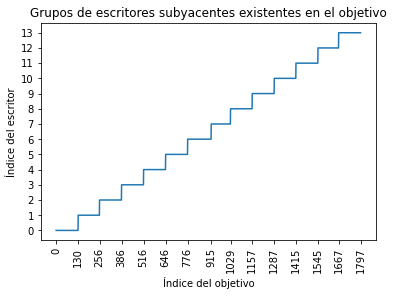

In [111]:
plt.plot(groups)
plt.yticks(np.unique(groups))
plt.xticks(writer_boundaries, rotation=90)
plt.xlabel("Índice del objetivo")
plt.ylabel("Índice del escritor")
_ = plt.title("Grupos de escritores subyacentes existentes en el objetivo")

Una vez que agrupamos los dígitos por escritor, podemos usar validación cruzada para tener esta información en cuenta: la clase conteniendo `Group` debe ser usada.

In [112]:
from sklearn.model_selection import GroupKFold

cv = GroupKFold()
test_score = cross_val_score(model, X, y, groups=groups, cv=cv,
                             n_jobs=2)
print(f"La precisión media es "
      f"{test_score.mean():.3f} +/- "
      f"{test_score.std():.3f}")

La precisión media es 0.920 +/- 0.021


Vemos que esta estrategia es menos optimista en lo que respecta al rendimiento de generalización del modelo. Sin embargo, este es más confiable si nuestro propósito es hacer reconocimiento de dígitos manuscritos por escritores independientes. Además, podemos ver que desviación estándar se ha reducido.

In [113]:
all_scores = pd.DataFrame(
    [test_score_no_shuffling, test_score_with_shuffling, test_score],
    index=["KFold sin mezclado", "KFold con mezclado",
           "KFold con grupos"],
).T

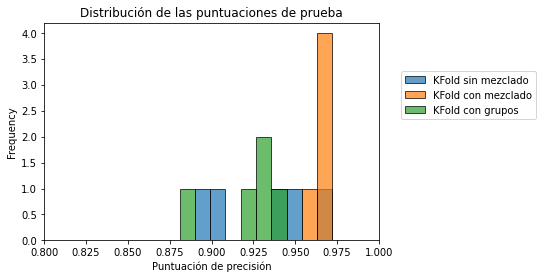

In [114]:
all_scores.plot.hist(bins=10, edgecolor="black", alpha=0.7)
plt.xlim([0.8, 1.0])
plt.xlabel("Puntuación de precisión")
plt.legend(bbox_to_anchor=(1.05, 0.8), loc="upper left")
_ = plt.title("Distribución de las puntuaciones de prueba")

Como conclusión, cuando evaluamos un modelo es realmente importante tener en cuenta cualquier patrón de agrupamiento de las muestras. De lo contario, los resultados obtenidos podrían ser demasiado optimistas respecto a la realidad.

## Sin datos i.i.d

En machine learning es bastante común asumir que los datos son i.i.d. (acrónimo inglés correspondiente a "*independent and identically distributed*", independientes e idénticamente distribuidos), lo que significa que el proceso generativo no tiene ninguna memoria de muestras pasadas para generar nuevas muestras.

Esta asunción es violada normalmente cuando tratamos con series temporales. Una muestra depende de información pasada.

Veremos un ejemplo para destacar estos problemas con datos no i.i.d en las estrategias de validación cruzada presentadas anteriormente. Vamos a cargar cotizaciones financieras de algunas empresas de energía.

In [115]:
import pandas as pd

symbols = {"TOT": "Total", "XOM": "Exxon", "CVX": "Chevron",
           "COP": "ConocoPhillips", "VLO": "Valero Energy"}
template_name = "../data/financial-data/{}.csv"

quotes = {}
for symbol in symbols:
    data = pd.read_csv(
        template_name.format(symbol), index_col=0, parse_dates=True
    )
    quotes[symbols[symbol]] = data["open"]
quotes = pd.DataFrame(quotes)

Vamos a empezar dibujando las diferentes cotizaciones financieras.

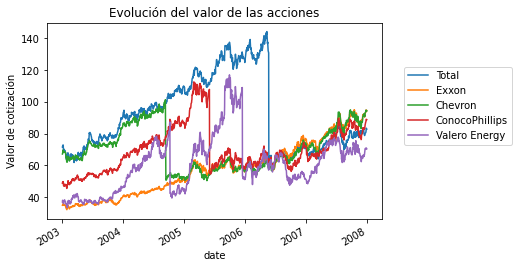

In [116]:
import matplotlib.pyplot as plt

quotes.plot()
plt.ylabel("Valor de cotización")
plt.legend(bbox_to_anchor=(1.05, 0.8), loc="upper left")
_ = plt.title("Evolución del valor de las acciones")

Vamos a repetir el experimento anterior. En lugar de usar datos aleatorios, esta vez usaremos cotizaciones reales. Aunque es obvio que un modelo predictivo no funciona en la práctica en datos aleatorios, esto es lo mismo con estos datos reales. Aquí queremos predecir la contización de Chevron usando loas cotizaciones de las otras compañías de energía.

Para hacer gráficos explicativos, usaremos una única división además de la validación cruzada que ya usamos anteriormente.

In [117]:
from sklearn.model_selection import train_test_split

X, y = quotes.drop(columns=["Chevron"]), quotes["Chevron"]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, shuffle=True, random_state=0)

Usaremos un árbol de decisión regresor que esperamos que tenga overfitting y, por tanto, no generalizará a datos no vistos. Usaremos una validación cruzada `ShuffleSplit` para comprobar el rendimiento de generalización de nuestro modelo.

In [118]:
from sklearn.tree import DecisionTreeRegressor

regressor = DecisionTreeRegressor()

In [119]:
from sklearn.model_selection import ShuffleSplit

cv = ShuffleSplit(random_state=0)

In [120]:
from sklearn.model_selection import cross_val_score

test_score = cross_val_score(regressor, X_train, y_train, cv=cv,
                             n_jobs=-1)
print(f"La medida de R2 es: "
      f"{test_score.mean():.2f} +/- {test_score.std():.2f}")

La medida de R2 es: 0.95 +/- 0.07


Sorprendentemente, hemos obtenido un rendimiento de generalización excepcional. Investigaremos y buscaremos la razón de tan buenos resultados con un modelo que se espera que falle. Anteriormente, hemos mencionado que `ShuffleSplit` es un esquema de validación cruzada iterativo que mezcla y divide datos. Simplificaremos este procedimiento con una única división y dibujaremos la predicción. Para este propósito podemos usar `train_test_split`.

In [121]:
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)
# Afecta el índice de `y_pred` para facilitar el dibujado
y_pred = pd.Series(y_pred, index=y_test.index)

Vamos a comprobar el rendimiento de generalización de nuestro modelo en esta división.

In [122]:
from sklearn.metrics import r2_score

test_score = r2_score(y_test, y_pred)
print(f"R2 en esta única división es: {test_score:.2f}")

R2 en esta única división es: 0.83


De forma similar, obtenemos buenos resultados en términos de $R^2$. Dibujaremos las muestras de entrenamiento, prueba y predicción.

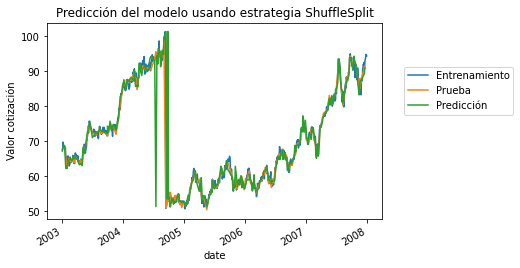

In [123]:
y_train.plot(label="Entrenamiento")
y_test.plot(label="Prueba")
y_pred.plot(label="Predicción")

plt.ylabel("Valor cotización")
plt.legend(bbox_to_anchor=(1.05, 0.8), loc="upper left")
_ = plt.title("Predicción del modelo usando estrategia ShuffleSplit")

Entonces, en este contexto, parece que las predicciones del modelo siguen las pruebas. Pero también podemos ver que las muestras de prueba están al lado de alguna muestra de entrenamiento. Y con estas series temporales vemos una relación entre un muestra en el momento `t` y una muestra en `t+1`. En este caso estamos violando la asuncion i.i.d. La idea a obtener es la siguiente: un modelo puede generar su conjunto de entrenamiento en el momento `t` para una muestra de prueba en el momento `t+1`. Esta predicción estaría cerca del valor real, incluso aunque nuestro modelo no aprendiera nada, solo memorizando el dataset de entrenamiento.

Una manera sencilla de verificar esta hipótesis es no mezclar los datos cuando hacemos la división. En este caso, usaremos el primer 75% de los datos para entrenar y los datos restantes para prueba.

In [124]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, shuffle=False, random_state=0,
)
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)
y_pred = pd.Series(y_pred, index=y_test.index)

In [125]:
test_score = r2_score(y_test, y_pred)
print(f"R2 en esta única división es: {test_score:.2f}")

R2 en esta única división es: -2.11


En este caso vemos que nuestro ya no es mágico. De hecho, su rendimiento es peor que sólo predecir la media del objetivo. Podemos comprobar visualmente qué estamos prediciendo.

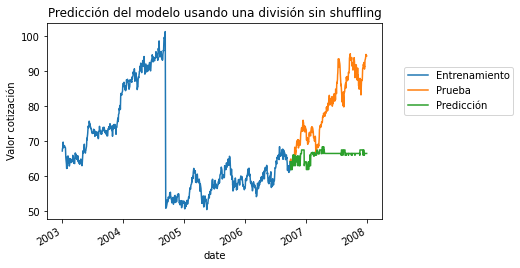

In [127]:
y_train.plot(label="Entrenamiento")
y_test.plot(label="Prueba")
y_pred.plot(label="Predicción")

plt.ylabel("Valor cotización")
plt.legend(bbox_to_anchor=(1.05, 0.8), loc="upper left")
_ = plt.title("Predicción del modelo usando una división sin shuffling")

Vemos que nuestro modelo no puede predecir nada porque no tiene muestras alrededor de la muestra de prueba. Comprobemos cómo podríamos haber hecho un esquema adecuado de validación cruzada para obtener una estimación razonable del rendimiento de generalización.

Una solución podría ser agrupar los ejemplos en bloques de tiempo, por ejemplo por cuatrimestres, y predecir la información de cada grupo usando información de los otros grupos. PAra este propósito, podemos usar la validación cruzada `LeaveOneGroupOut`.

In [132]:
from sklearn.model_selection import LeaveOneGroupOut

groups = quotes.index.to_period("Q")
cv = LeaveOneGroupOut()
test_score = cross_val_score(regressor, X, y,
                             cv=cv, groups=groups, n_jobs=-1)
print(f"La R2 media es: "
      f"{test_score.mean():.2f} +/- {test_score.std():.2f}")

La R2 media es: -0.83 +/- 1.62


En este caso, vemos que no podemos hacer buenas predicciones, lo que es menos sorprendente que nuestra resultados originales.

Otra cosa a considerar es la aplicación real de nuestra solución. Si nuestro modelo tiene como objetivo la previsión (es decir, predicción de datos futuros a partir de datos pasados), no debemos usar datos de entrenamiento que sean posteriores a los datos de prueba. En este caso, podemos usar la validación `TimeSeriesSplit` para forzar este comportamiento.

In [134]:
from sklearn.model_selection import TimeSeriesSplit

cv = TimeSeriesSplit(n_splits=groups.nunique())
test_score = cross_val_score(regressor, X, y,
                             cv=cv, groups=groups, n_jobs=2)
print(f"La R2 media es: "
      f"{test_score.mean():.2f} +/- {test_score.std():.2f}")

La R2 media es: -5.44 +/- 16.64


En conclusión, es importante no usar una estrategia de validación cruzada que no respete algunas asunciones, como tener datos i.i.d. Podría conducir a obtener resultados absurdos que podrían hacer pensar que un modelo predictivo podría funcionar.